<a href="https://colab.research.google.com/github/haresh93/ERA-submissions/blob/main/S7/Step_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **TARGET**
1. Setting up the transforms
2. Settings up the Data Loaders
3. Setting up the Base Working Model
4. Setting up basic training and Test Loop

### **RESULTS**
1. Parameters: 6.3M
2. Best Training Accuracy: 100%
3. Best Test Accuracy: 99.30%

### **Analysis**
1. Extremely Heavy Model
2. Model is sort of over fitted.

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [4]:
# Train and Test Transforms
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Train and Test Datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 243751458.35it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 52967072.07it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71220021.38it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18230171.07it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
from utils import print_train_data_stats

print_train_data_stats()

100%|██████████| 9912422/9912422 [00:00<00:00, 217500791.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107580545.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71085326.31it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [8]:
from model import model_summary, Net1

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net1().to(device)

model_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
        MaxPool2d-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 512, 5, 5]       1,180,160
             ReLU-12            [-1, 512, 5, 5]               0
           Conv2d-13           [-1, 1024, 3, 3]       4,719,616
             ReLU-14           [-1, 102

In [9]:
from model import Net1, model_train, model_test, draw_graphs
model =  Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, epoch)
    model_test(model, device, test_dataloader)

EPOCH: 0


Train: Loss=0.0963 Batch_id=468 Accuracy=87.38: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0668, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Train: Loss=0.0131 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Train: Loss=0.0209 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]



Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Train: Loss=0.0065 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]



Test set: Average loss: 0.0276, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Train: Loss=0.0034 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]



Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Train: Loss=0.0235 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]



Test set: Average loss: 0.0325, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Train: Loss=0.0243 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]



Test set: Average loss: 0.0350, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Train: Loss=0.0263 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]



Test set: Average loss: 0.0343, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Train: Loss=0.0004 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]



Test set: Average loss: 0.0300, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Train: Loss=0.0131 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]



Test set: Average loss: 0.0288, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Train: Loss=0.0000 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0289, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Train: Loss=0.0003 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]



Test set: Average loss: 0.0297, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Train: Loss=0.0002 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0297, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Train: Loss=0.0006 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]



Test set: Average loss: 0.0291, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Train: Loss=0.0357 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0419, Accuracy: 9900/10000 (99.00%)

EPOCH: 15


Train: Loss=0.0003 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]



Test set: Average loss: 0.0354, Accuracy: 9915/10000 (99.15%)

EPOCH: 16


Train: Loss=0.0001 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0284, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Train: Loss=0.0001 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]



Test set: Average loss: 0.0338, Accuracy: 9915/10000 (99.15%)

EPOCH: 18


Train: Loss=0.0011 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:22<00:00, 20.94it/s]



Test set: Average loss: 0.0333, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Train: Loss=0.0000 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]



Test set: Average loss: 0.0336, Accuracy: 9926/10000 (99.26%)



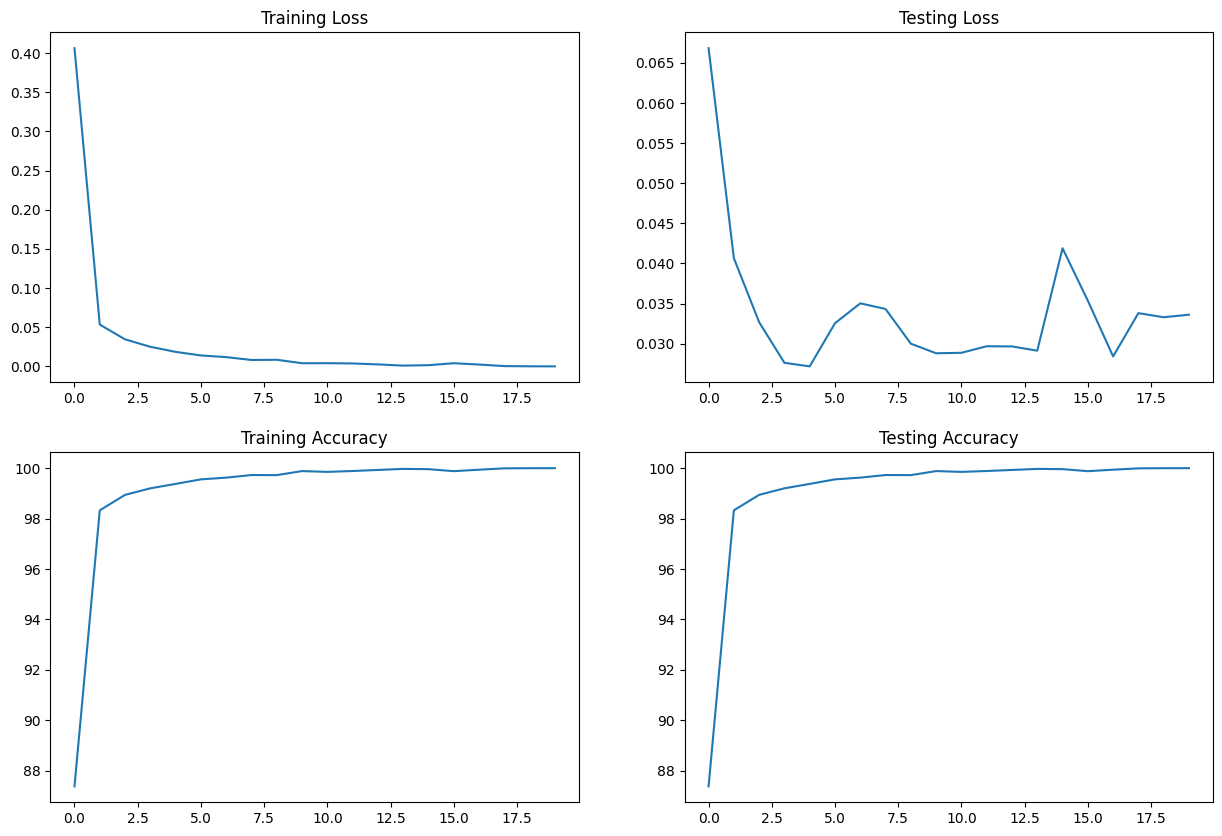

In [10]:
draw_graphs()